In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from dataset import *
from model import *
import datetime
import scipy
import librosa
import os
import generated.fragment_resolver_pb2 as fragment_resolver

device = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(device, True)
tf.config.run_functions_eagerly(False)

# tf.keras.backend.set_floatx('float32')

In [2]:
def plot_data(samples, num_grid_cells=None, *yolo_outputs):
    fig = plt.figure()
    ax = fig.gca()
    color_alpha_per_fragment = 0.5 / len(yolo_outputs)
    
    encoded_fragments = yolo_decoder(tf.constant(list(yolo_outputs))).merge_dims(0, 1)  
    fragment_protos = fragment_decoder.decode_fragments_to_proto(encoded_fragments)[0].numpy()
    audio_fragments = fragment_resolver.FragmentResolverModelResponse()
    audio_fragments.ParseFromString(fragment_protos)
    
    for fragment in sorted(audio_fragments.fragments, key=lambda fragment: fragment.startUs):
        fragment_start_offset = int(fragment.startUs / (1e6 / sample_rate))
        fragment_end_offset = int(fragment.endUs / (1e6 / sample_rate))
        fragment_duration = fragment_end_offset - fragment_start_offset
        print(fragment)
        rect = plt.Rectangle((fragment_start_offset, -0.5), fragment_duration, 1, fc=(1, 0, 0, color_alpha_per_fragment))
        ax.add_patch(rect)
    
    ax.plot(samples, zorder=-1)
    if num_grid_cells:
        for i_cell in range(num_grid_cells):
            rect = plt.Rectangle((i_cell * samples.shape[0] / num_grid_cells, -1), samples.shape[0] / num_grid_cells, 2, ec='black', fc='none')
            ax.add_patch(rect)
            
def plot_stft(samples):
    nfft = 1024
    fs = 32768
    samples = np.squeeze(samples, axis=-1)
    f, t, stft = scipy.signal.stft(samples, fs, nperseg=nfft, noverlap=nfft-16)
    threshold_ghz = f < 900
    f = f[threshold_ghz]
    threshold_ghz = np.transpose(np.tile(threshold_ghz, (t.shape[0], 1)))
    stft = np.reshape(stft[threshold_ghz], (f.shape[0], t.shape[0]))
    stft = np.abs(stft)
    stft = librosa.power_to_db(stft, amin=1e-5, top_db=80.0)
    print(np.max(stft))
    print(np.min(stft))

    fig = plt.figure()
    ax = fig.gca()
#     ax.plot(stft.sum(axis=-2))
    stft = scipy.ndimage.gaussian_filter(stft, sigma=(9, 0))
    ax.pcolormesh(t, f, stft, shading='gouraud', cmap='inferno')
    print(stft.shape)
    
def is_data():
    global data
    try:
        data = data
        return True
    except NameError:
        return False

class EpochCounter(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_counter = 0
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_counter += 1
        print(f'Epoch counter = {self.epoch_counter}')

In [3]:
cwd = os.getcwd()
seed = 4221
batch_size = 8
sample_rate = 32758
min_duration_sec = 5
max_shift_duration_sec = 2
num_grid_cells = 20
# yolo_encoding_type = 'START_DURATION'
yolo_encoding_type = 'CENTER_DURATION'
fragments_dtype = tf.float32.name

input_length = int(sample_rate * min_duration_sec)
model_params = {
    fragment_resolver.ResolvedTransformer.Type.SILENCE: {
        'silenceDurationUs': LinearTransformerNormalizerLayer(5e5, in_dtype=tf.int64)
    },
#     fragment_resolver.Transformer.TransformerType.TYPE2: {
#         'typeType2Param2': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64), 
#           'typeType2Param3': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64), 
#           'typeType2Param4': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64)
#     },
#     fragment_resolver.Transformer.TransformerType.TYPE3: {
#         'typeType3Param5': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64), 
#         'typeType3Param6': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64)
#     }
}

with open(os.path.join(cwd, 'generated', 'descriptor_set.desc'), 'rb') as desc_file:
    protobuf_descriptor = desc_file.read()
data_path = os.path.join(cwd, '..', 'data', 'clips', 'labeled')
train_data_path = os.path.join(data_path, 'train')
val_data_path = os.path.join(data_path, 'train')

train_data_generator = AudioDataJsonToProtoGenerator(train_data_path)
val_data_generator = AudioDataJsonToProtoGenerator(val_data_path)
fragment_encoder = ProtoFragmentBatchEncoderLayer(sample_rate, model_params, protobuf_descriptor, fragments_dtype)
fragment_decoder = ProtoFragmentBatchDecoderLayer(sample_rate, model_params, protobuf_descriptor)
audio_decoder = AudioDecoder(sample_rate)
# Prepare default padding transformer
default_padding_transformer = fragment_resolver.ResolvedTransformer() 
default_padding_transformer.type = fragment_resolver.ResolvedTransformer.Type.SILENCE
default_padding_transformer.silenceDurationUs = 0
default_padding_transformer = default_padding_transformer.SerializeToString()
default_padding_transformer = fragment_encoder.encode_transformers_to_tensor(default_padding_transformer)[0]

data_augmenter = AudioDataShiftAugmenterLayer(sample_rate, max_shift_duration_sec, seed)
data_padder = AudioDataPadderLayer(sample_rate, min_duration_sec, min_duration_sec * 0.01, default_padding_transformer)
data_splitter = AudioDataUniformSplitterLayer(sample_rate, min_duration_sec, min_duration_sec / num_grid_cells * 4, min_duration_sec * 0.01, False)
yolo_encoder = YoloOutputEncoderLayer(num_grid_cells, input_length, yolo_encoding_type, False)
yolo_decoder = YoloOutputDecoderLayer(input_length, 0.5, yolo_encoding_type, fragments_dtype)
yolo_validator = YoloOutputValidatorLayer()

# train_source_dataset = tf.data.Dataset\
#             .from_generator(train_data_generator.generate, 
#                             output_signature=(
#                                 tf.TensorSpec(shape=(None), dtype=tf.string),
#                                 tf.TensorSpec(shape=(None), dtype=tf.string)
#                             ))
train_source_dataset = tf.data.experimental.load(os.path.join(data_path, 'train_ds_enc_' + yolo_encoding_type.lower()))
# print('Train source dataset loaded')
train_dataset = train_source_dataset\
            .cache()\
            .repeat()\
            .map(lambda audio_path, fragments_proto: (audio_path, fragment_encoder.encode_fragments_to_tensor(fragments_proto)))\
            .map(lambda audio_path, fragments: (audio_decoder.decode(audio_path), fragments))\
            .map(data_augmenter.augment_samples)\
            .map(data_padder.pad_samples)\
            .flat_map(data_splitter.split_into_frames)\
            .map(lambda samples, fragments: (samples, yolo_encoder.encode(fragments)))\
            .filter(lambda samples, yolo_output: yolo_validator.is_valid(yolo_output))\
            .shuffle(batch_size * 8, seed, reshuffle_each_iteration=True)\
            .batch(batch_size)

# val_source_dataset = tf.data.Dataset\
#             .from_generator(val_data_generator.generate, 
#                             output_signature=(
#                                 tf.TensorSpec(shape=(None), dtype=tf.string),
#                                 tf.TensorSpec(shape=(None), dtype=tf.string)
#                             ))\
#             .map(lambda audio_path, fragments_proto: (audio_path, fragment_encoder.encode_fragments_to_tensor(fragments_proto)))\
#             .map(lambda audio_path, fragments: (audio_decoder.decode(audio_path), fragments))\
#             .map(data_padder.pad_samples)\
#             .flat_map(data_splitter.split_into_frames)\
#             .map(lambda samples, fragments: (samples, yolo_encoder.encode(fragments)))\
#             .filter(lambda samples, yolo_output: yolo_validator.is_valid(yolo_output))\
#             .cache()
val_source_dataset = tf.data.experimental.load(os.path.join(data_path, 'validation_ds_enc_' + yolo_encoding_type.lower()))
print('Validation source dataset loaded')
val_dataset = val_source_dataset.batch(batch_size)
            
data = list(val_dataset.take(1).as_numpy_iterator())[0]
data = list(zip(data[0], data[1]))
data

Validation source dataset loaded


[(array([[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.0049568 ],
         [0.00876785],
         [0.00444154]], dtype=float32),
  array([[1.        , 0.33600003, 0.0336    , 1.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [1.        , 0.8080001 , 0.06      , 1.        , 0.4       ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.  

In [13]:
model = YoloModel7(input_length, num_grid_cells, fragment_encoder.transformer_output_length)
display(model.summary())

train_results_filepath = os.path.join(cwd, '..', 'results', 'trained_models')
checkpoint_filepath = os.path.join(train_results_filepath, '7_1_cpt.h5')
epoch_ctr = EpochCounter()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 163790, 1)]  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 163790, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
stft_1 (STFT)                   (None, 10240, 32, 1) 0           lambda_6[0][0]                   
__________________________________________________________________________________________________
magnitude_1 (Magnitude)         (None, 10240, 32, 1) 0           stft_1[0][0]                     
____________________________________________________________________________________________

None

In [5]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_bounds_metric',
            mode='min',
            save_best_only=True)

In [6]:
yolo_loss = YoloLossFunction(num_grid_cells, input_length, 
                {'l_cbf': 10.0, 'l_cubf': 10.0, 'l_isobj': 1.0, 'l_noobj': 0.5, 'l_class': 70.0}, yolo_encoding_type)

start_metric = YoloLossFunction(num_grid_cells, input_length,
                {'l_cbf': 1.0, 'l_cubf': 0.0, 'l_isobj': 0, 'l_noobj': 0, 'l_class': 0}, yolo_encoding_type, name='start_metric')
duration_metric = YoloLossFunction(num_grid_cells, input_length,
                {'l_cbf': 0.0, 'l_cubf': 1.0, 'l_isobj': 0, 'l_noobj': 0, 'l_class': 0}, yolo_encoding_type, name='duration_metric')
class_metric = YoloLossFunction(num_grid_cells, input_length,
                {'l_cbf': 0, 'l_cubf': 0, 'l_isobj': 0, 'l_noobj': 0, 'l_class': 1.0}, yolo_encoding_type, name='class_metric')
bounds_metric = YoloLossFunction(num_grid_cells, input_length,
                {'l_cbf': 1.0, 'l_cubf': 1.0, 'l_isobj': 0, 'l_noobj': 0, 'l_class': 0}, yolo_encoding_type, name='bounds_metric')

model.compile(
    loss=yolo_loss,
    metrics=[start_metric, duration_metric, class_metric, bounds_metric],
#     optimizer='adagrad'
#     optimizer='rmsprop'
#     optimizer='adam'
#     optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001)#, clipnorm=0.01)
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005)
#     optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, centered=True)
)


In [7]:
num_epochs = 1000
while epoch_ctr.epoch_counter < num_epochs:
    try:
        model.fit(train_dataset, epochs=num_epochs, initial_epoch=epoch_ctr.epoch_counter, 
                  verbose=1, steps_per_epoch=640/batch_size,
                  validation_data=val_dataset, 
                  callbacks=[epoch_ctr, model_checkpoint_callback])
    except KeyboardInterrupt:
        break
    except Exception as e:
        print(e)
        break

Epoch 1/1000
15/80 [====>.........................] - ETA: 14s - loss: 457.4978 - start_metric: 0.9855 - duration_metric: 35.1427 - class_metric: 1.0338 - bounds_metric: 36.1282

<IPython.core.display.Javascript object>


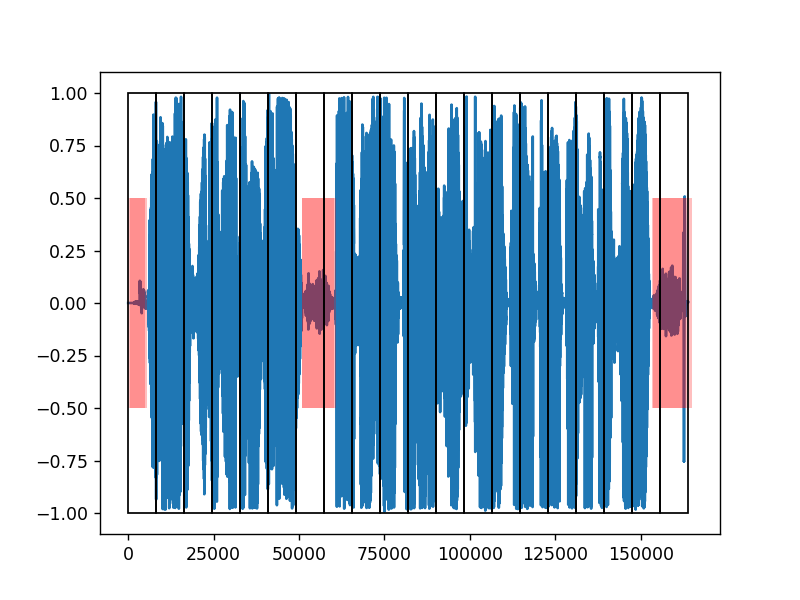

endUs: 167989
transformer {
}

startUs: 12058
endUs: 147597
transformer {
  silenceDurationUs: 317144
}

startUs: 1551987
endUs: 1852005
transformer {
  silenceDurationUs: 200000
}

startUs: 1552017
endUs: 1837139
transformer {
  silenceDurationUs: 453263
}

startUs: 4674583
endUs: 5034587
transformer {
  silenceDurationUs: 200000
}

startUs: 4689144
endUs: 4980920
transformer {
  silenceDurationUs: 392939
}



<IPython.core.display.Javascript object>


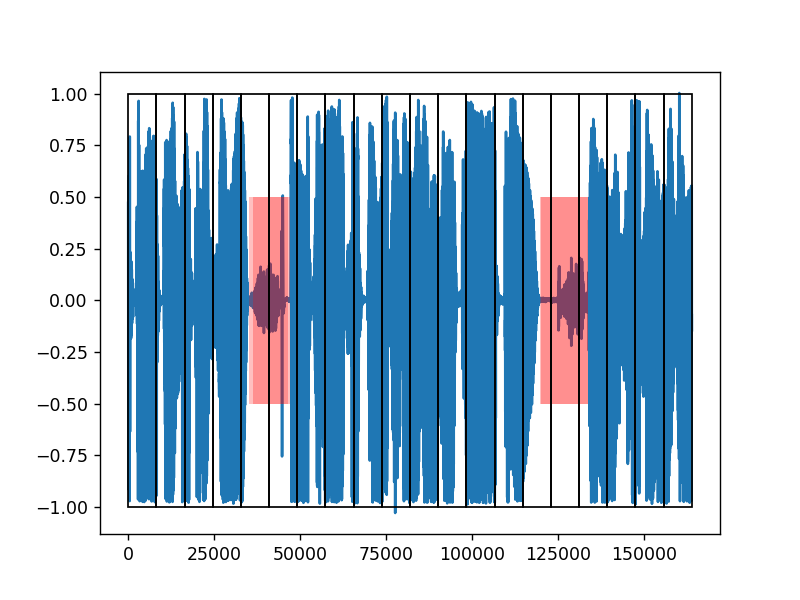

startUs: 1075004
endUs: 1435008
transformer {
  silenceDurationUs: 200000
}

startUs: 1111270
endUs: 1418767
transformer {
  silenceDurationUs: 427985
}

startUs: 3652268
endUs: 4076256
transformer {
  silenceDurationUs: 200000
}

startUs: 3665913
endUs: 4081506
transformer {
  silenceDurationUs: 437403
}



In [20]:
if is_data():
    data_indexes = [i for i in range(2)]
    for data_index in data_indexes:
        predicted = model.predict(tf.constant([data[data_index][0]]))[0]
        plot_data(data[data_index][0], num_grid_cells, predicted, data[data_index][1])

In [24]:
model.optimizer.learning_rate.assign(0.001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

In [19]:
model.load_weights(os.path.join(train_results_filepath, '7_fin.h5'))

In [ ]:
model.save(os.path.join(train_results_filepath, '7_fin.h5'))

In [10]:
yolo_loss.set_lambdas({
    'l_start': 10.0, 'l_duration': 10.0, 'l_isobj': 1.0, 
    'l_noobj': 0.5, 'l_class': 10.0
})

In [8]:
tf.data.experimental.save(train_source_dataset, os.path.join(data_path, 'train_ds_enc_' + yolo_encoding_type.lower()))
print('saved train dataset')
tf.data.experimental.save(val_source_dataset, os.path.join(data_path, 'validation_ds_enc_' + yolo_encoding_type.lower()))
print('saved validation dataset')

saved train dataset
saved validation dataset


<IPython.core.display.Javascript object>


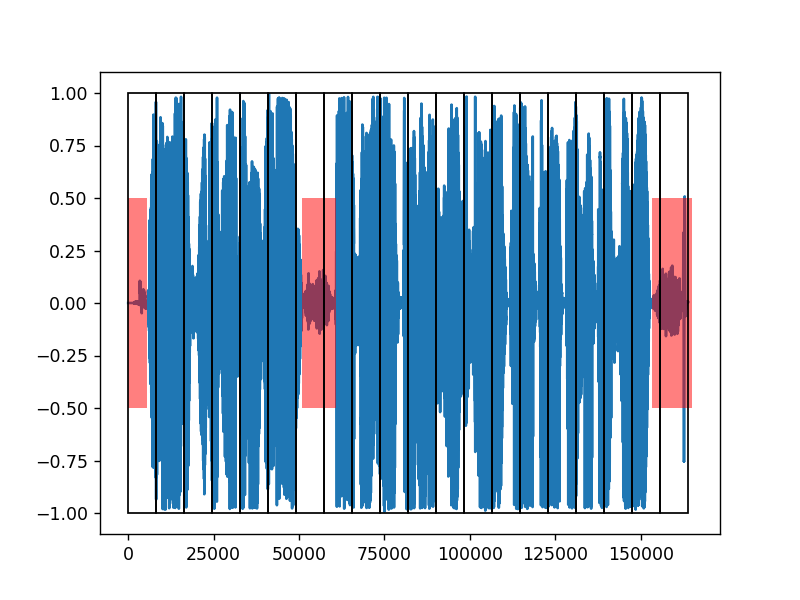

endUs: 167989
transformer {
}

startUs: 1551987
endUs: 1852005
transformer {
  silenceDurationUs: 200000
}

startUs: 4674583
endUs: 5034587
transformer {
  silenceDurationUs: 200000
}



<IPython.core.display.Javascript object>


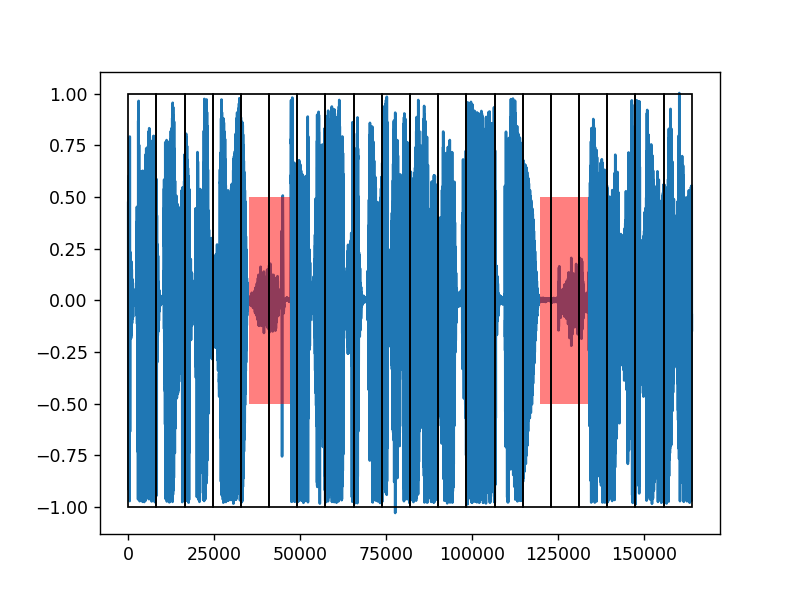

startUs: 1075004
endUs: 1435008
transformer {
  silenceDurationUs: 200000
}

startUs: 3652268
endUs: 4076256
transformer {
  silenceDurationUs: 200000
}



In [12]:
if is_data():
    data_indexes = [0, 1]#, 2, 3, 4]
    for data_index in data_indexes:
        plot_data(data[data_index][0], num_grid_cells, data[data_index][1])
#         plot_stft(data[data_index][0])